# Build and train logistic regression
## Purpose
In this example we will demonstrate how to:

   - Build a Coreset tree for logistic regression on a train dataset.
   - Train a LogisticRegression model using the coreset tree service method
   - Compare the model's quality to a model build on the entire dataset
   - Add to the Coreset tree additional data through partial_build
   - Train a model directly on the Coreset tree using the fit function
   - Compare again the model's quality to a model build on the entire dataset

In this example we'll be using the well-known Covertype Dataset (https://archive.ics.uci.edu/ml/datasets/covertype). We will split the data to three parts:
   - train_1 - 50% of the data
   - train_2 - 20% of the data
   - test - 30% of the data

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_covtype
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from dataheroes import CoresetTreeServiceLG

warnings.filterwarnings('ignore', category=DeprecationWarning)

## Prepare datasets

In [2]:
# Load Covertype dataset as a pandas data frame.
# In the output data frame all columns are features beside the last column.
# The last column (Cover_Type) is the target
df = fetch_covtype(as_frame=True).frame

# Split dataset: train_1 = 50%, train_2=20%, test=30%
train, test = train_test_split(df, test_size=0.3, random_state=42)
train_1, train_2 = train_test_split(train, test_size=20/70, random_state=42)

n_samples_full = train_1.shape[0]

# Prepare the data directory and set the file names.
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)
train_1_file_path = data_dir / "train_1.csv"
train_2_file_path = data_dir / "train_2.csv"
test_file_path = data_dir / "test.csv"

# Store datasets as CSV.
# We use the data frame index as the unique identifier and define a column for it (index_column)
# Defining an index column is optional. In this example we set it to have a reference to the original dataset.
train_1.to_csv(train_1_file_path, index_label="index_column")
train_2.to_csv(train_2_file_path, index_label="index_column")
test.to_csv(test_file_path, index_label="index_column")

## 1. Build the tree
Run `build_from_file` on the first train file.
It will include ~290K sample. We pass `n_classes` and `n_instances` to help the tree calculate an optimal Coreset size.

In [3]:
# Tell the tree how the data is structured.
# In this example we have an index column and a target column.
# All other columns are features.
data_params = {
    'target': {'name': 'Cover_Type'},
    'index': {'name': 'index_column'}
}
# Initialize the service and build the tree.
# The tree uses the local file system to store its data.
# After this step you will have a new directory .dataheroes_cache
service_obj = CoresetTreeServiceLG(data_params=data_params,
                                   optimized_for='training',
                                   n_classes=7,
                                   n_instances=n_samples_full
                                  )
service_obj.build_from_file(train_1_file_path)

## 2. Plot the tree

{'training': WindowsPath('output/training_tree_20231127_165508.png')}

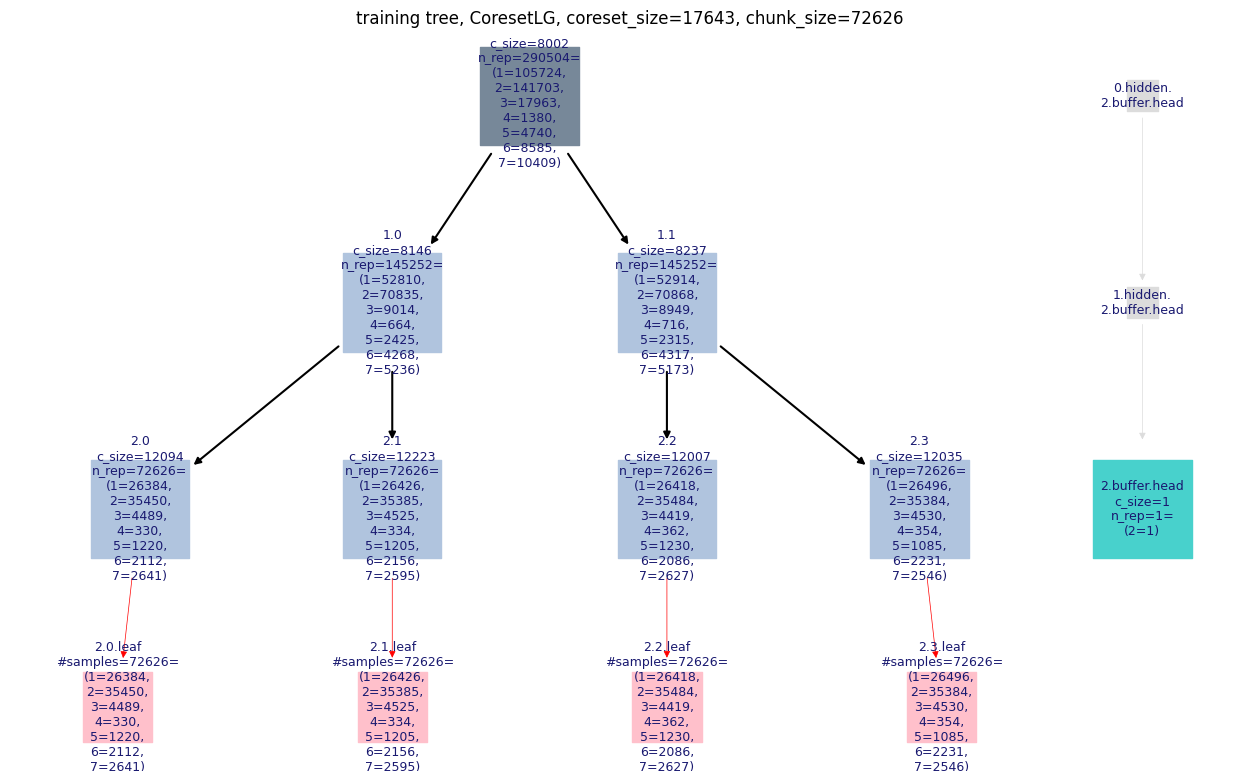

In [4]:
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)
service_obj.plot(output_dir)

## 3. Get coreset from the tree, train a model based on it

In [5]:
# Ignore convergence warnings for logistic regression
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


# Train a logistic regression model on the coreset.
# Since we are using LogisticRegression there is not need to pass the model to the service because the default for the service object is LogisticRegression.
service_obj.fit()
n_samples_coreset = service_obj.get_coreset_size()

## 4.1. Train a model on the full dataset for comparison
We use the same part of the dataset that was used for building the tree

In [6]:
X = train_1.iloc[:, :-1].to_numpy() 
y = train_1.iloc[:, -1].to_numpy()

full_dataset_model = LogisticRegression().fit(X, y)
n_samples_full = len(y)

### 4.2. Compare models quality
Test both coreset and full model on test dataset and compare their AUC scores

In [7]:
# Read test dataset from file
test_df = pd.read_csv(test_file_path)
X_test = df.iloc[:, :-1].to_numpy()
y_test = df.iloc[:, -1].to_numpy()

# Evaluate model
coreset_score = roc_auc_score(y_test, service_obj.predict_proba(X_test), multi_class='ovr')
full_dataset_score = roc_auc_score(y_test, full_dataset_model.predict_proba(X_test), multi_class='ovr')

print(f"Coreset AUC score ({n_samples_coreset:,} samples): {coreset_score}")
print(f"Full dataset AUC score ({n_samples_full:,} samples): {full_dataset_score}")

Coreset AUC score (8,003 samples): 0.8089910597357953
Full dataset AUC score (290,505 samples): 0.7903846653104264


## 5.1. Save the tree for later use

In [8]:
out_dir = Path('output')
out_dir.mkdir(exist_ok=True)
save_tree_name = 'train_1_coreset_tree'
service_obj.save(out_dir, save_tree_name, override=True)

WindowsPath('output/train_1_coreset_tree')

### 5.2. Load the saved tree

In [9]:
service_obj = CoresetTreeServiceLG.load(out_dir, save_tree_name)

## 6. Partial build
Add the second train dataset to the tree using `partial_build_from_file`.

In [10]:
service_obj.partial_build_from_file(train_2_file_path)

## 7. Fit on the tree
Run `fit` directly on the tree

In [11]:
service_obj.fit()
n_samples_coreset = service_obj.get_coreset_size()

## 8. Save coreset

In [12]:
final_coreset_path = os.path.join(output_dir, "final_coreset")
service_obj.save_coreset(final_coreset_path)

## 9.1 Train model of entire dataset
Train model of entire train dataset to compare AUC score with coreset

In [13]:
X = train.iloc[:, :-1].to_numpy()
y = train.iloc[:, -1].to_numpy()

full_updated_dataset_model = LogisticRegression().fit(X, y)
n_samples_full = len(y)

### 9.2 Compare models quality

In [14]:
final_tree_lg_score = roc_auc_score(y_test, service_obj.predict_proba(X_test), multi_class='ovr')
full_updated_dataset_score = roc_auc_score(y_test, full_updated_dataset_model.predict_proba(X_test), multi_class='ovr')

print(f"Updated Coreset AUC score ({n_samples_coreset:,} samples): {final_tree_lg_score}")
print(f"Full updated dataset AUC score ({n_samples_full:,} samples): {full_updated_dataset_score}")

Updated Coreset AUC score (27,391 samples): 0.8271783246587726
Full updated dataset AUC score (406,708 samples): 0.8013954560508308
